In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import selection_tests

In [2]:
# Modify the dataset by filling NaNs and dropping NO BIDS
mich_bids = pd.read_csv('panel.csv')
mich_bids[['Bid Per Unit','Highest']] = mich_bids[['Bid Per Unit','Highest']].fillna(0)

#add constant
mich_bids = sm.add_constant(mich_bids)

#units
unit_dummies = pd.get_dummies(mich_bids['Units'])
unit_dummies_name =  list(unit_dummies.columns)
mich_bids[unit_dummies_name]  = unit_dummies

#years
year_dummies = pd.get_dummies(mich_bids['month_year'].apply(lambda x : x[0:4]))
year_dummies_name = list(year_dummies.columns)
mich_bids[year_dummies_name]  = year_dummies


#interact stuff with units  'Highest',
x_names_raw = ['const', 'Estimated Volume', 'Appraised Value Per Unit']
x_names_cov = []
for unit in ['MBF','Cords']: #unit_dummies_name:
    for x_name in x_names_raw:
        x_names_cov.append('%s*%s'%(x_name,unit))
        mich_bids['%s*%s'%(x_name,unit)] = mich_bids[x_name]*mich_bids[unit]
        
mich_bids['Estimated Volume*Appraised Value Per Unit']  = mich_bids['Estimated Volume']*mich_bids['Appraised Value Per Unit']

/home/erichschulman/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


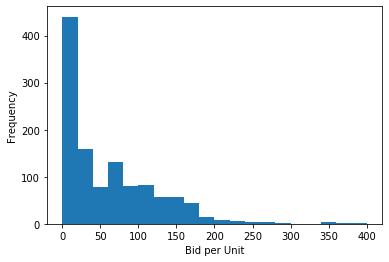

In [3]:

plt.hist(mich_bids['Bid Per Unit'][mich_bids['Bid Per Unit']!=0],bins=20, range=(0,400))
plt.xlabel('Bid per Unit')
plt.ylabel('Frequency')
plt.savefig('bids_hist.png')
plt.show()


In [4]:
# Fit the model with ols = True
x_names_raw = ['const', 'Estimated Volume', 'Appraised Value Per Unit']
x_names = x_names_cov #(x_names_raw + unit_dummies_name[1:] )  #+ ['Estimated Volume*Appraised Value Per Unit']  
          #+ year_dummies_name[1:]) #

#different datasets
mich_bids_nozeros = mich_bids[mich_bids['Bid Per Unit']!=0]
mich_bids_cords = mich_bids[mich_bids['Units']!='Acres']
mich_bids_cordsnozeros = mich_bids[ (mich_bids['Units']!='Acres') & (mich_bids['Bid Per Unit']!=0) ]

#setup x/y
x = mich_bids_cords[x_names ].copy()
y = mich_bids_cords['Bid Per Unit']

ols_model = sm.OLS(y,x).fit()
print(ols_model.summary().as_latex())

# seems like year fixed effects are not predictive
# also seems like estimated volume doesn't matter
# seems like apraised value is the only thing
# only like 13 observations with acres

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                 &   Bid Per Unit   & \textbf{  R-squared:         } &     0.140   \\
\textbf{Model:}                         &       OLS        & \textbf{  Adj. R-squared:    } &     0.139   \\
\textbf{Method:}                        &  Least Squares   & \textbf{  F-statistic:       } &     111.2   \\
\textbf{Date:}                          & Wed, 19 May 2021 & \textbf{  Prob (F-statistic):} & 3.76e-109   \\
\textbf{Time:}                          &     21:26:30     & \textbf{  Log-Likelihood:    } &   -17804.   \\
\textbf{No. Observations:}              &        3412      & \textbf{  AIC:               } & 3.562e+04   \\
\textbf{Df Residuals:}                  &        3406      & \textbf{  BIC:               } & 3.566e+04   \\
\textbf{Df Model:}                      &           5      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                               

In [5]:
tobit_model = selection_tests.Tobit(y,x, ols=True).fit()
print(tobit_model.summary().as_latex())

Optimization terminated successfully.
         Current function value: 5.218085
         Iterations: 206
         Function evaluations: 327
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                 &    Bid Per Unit    & \textbf{  Log-Likelihood:    } &   -17804.   \\
\textbf{Model:}                         &       Tobit        & \textbf{  AIC:               } & 3.562e+04   \\
\textbf{Method:}                        & Maximum Likelihood & \textbf{  BIC:               } & 3.566e+04   \\
\textbf{Date:}                          &  Wed, 19 May 2021  & \textbf{                     } &             \\
\textbf{Time:}                          &      21:26:31      & \textbf{                     } &             \\
\textbf{No. Observations:}              &         3412       & \textbf{                     } &             \\
\textbf{Df Residuals:}                  &         3406       & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabu

In [6]:
# Fit the model with ols = False
tobit_model = selection_tests.Tobit(y,x).fit()
tobit_model.summary().as_latex()

/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


'\\begin{center}\n\\begin{tabular}{lclc}\n\\toprule\n\\textbf{Dep. Variable:}                 &    Bid Per Unit    & \\textbf{  Log-Likelihood:    } &   -8235.6   \\\\\n\\textbf{Model:}                         &       Tobit        & \\textbf{  AIC:               } & 1.648e+04   \\\\\n\\textbf{Method:}                        & Maximum Likelihood & \\textbf{  BIC:               } & 1.652e+04   \\\\\n\\textbf{Date:}                          &  Wed, 19 May 2021  & \\textbf{                     } &             \\\\\n\\textbf{Time:}                          &      21:26:32      & \\textbf{                     } &             \\\\\n\\textbf{No. Observations:}              &         3412       & \\textbf{                     } &             \\\\\n\\textbf{Df Residuals:}                  &         3406       & \\textbf{                     } &             \\\\\n\\bottomrule\n\\end{tabular}\n\\begin{tabular}{lcccccc}\n                                        & \\textbf{coef} & \\textbf{std err} &

In [12]:
# Fit the regular test model
regular_test_model = selection_tests.regular_test(y,x,selection_tests.setup_test)
regular_test_model

/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-8234.34171698352 -17804.106633391522 9569.764916408007 3.2148973728127666 50.96002640347636
50.96002640347636 3.2148973728127666


(1, 50.96002640347636)

In [13]:
# Fit the bootstrap test model
bootstrap_test_model = selection_tests.bootstrap_test(y,x,selection_tests.setup_test, trials=100)
bootstrap_test_model

/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9577.330496516886+3.7862429810803705e-17j) (187.789638110454+0j)


(1,
 (39.05766877082215+1.4820596196143397e-19j),
 (65.0249822004796+2.5239173059891435e-19j))

In [30]:
selection_tests.test_table(y,x,selection_tests.setup_test, trials=100)

/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


V ----
(7.565580108879794+3.7862429810803705e-17j)
----
---- bootstrap: llr, omega ----
(9577.330496516886+3.7862429810803705e-17j) (187.789638110454+0j)
----


/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


regular: test, llr, omega ----
50.96002640347636 9569.764916408007 3.2148973728127666
---- 
\begin{center}
\begin{tabular}{cccc}
\toprule
\textbf{Version} & \textbf{Result} & \textbf{Stat} & \textbf{95 \% CI} \\ \midrule
Bootstrap & H1 & -- & [38.138, 65.737] \\
Classical & H1 & 50.960 & [1.959, 1.959] \\
\bottomrule
\end{tabular}
\end{center}


../selection_tests.py:217: ComplexWarning: Casting complex values to real discards the imaginary part
